<a href="https://colab.research.google.com/github/ytabatabaee/Deep-Learning-Material/blob/master/session10/Simple_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Net Example



## Installing Torch Geometric

In [1]:
!pip install torch-geometric \
  torch-sparse==latest+cu101 \
  torch-scatter==latest+cu101 \
  torch-cluster==latest+cu101 \
  -f https://pytorch-geometric.com/whl/torch-1.7.0.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
  Using cached https://pytorch-geometric.com/whl/torch-1.7.0/torch_sparse-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Using cached https://pytorch-geometric.com/whl/torch-1.7.0/torch_scatter-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Using cached https://pytorch-geometric.com/whl/torch-1.7.0/torch_cluster-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torch-sparse 0.6.8
    Uninstalling torch-sparse-0.6.8:
      Successfully uninstalled torch-sparse-0.6.8
  Found existing installation: torch-scatter 2.0.5
    Uninstalling torch-scatter-2.0.5:
      Successfully uninstalled torch-scatter-2.0.5
  Found existing installation: torch-cluster 1.5.8
    Uninstalling torch-cluster-1.5.8:
      Successfully uninstalled torch-cluster-1.5.8


## Importing Libraries

In [2]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

## Loading & Visualizing Dataset

In [13]:
def plot_dataset(dataset):
    plt.rcParams["figure.figsize"] = (20,20)
    edges_raw = dataset.data.edge_index.numpy()
    edges = [(x, y) for x, y in zip(edges_raw[0, :], edges_raw[1, :])]
    labels = dataset.data.y.numpy()

    G = nx.Graph()
    G.add_nodes_from(list(range(np.max(edges_raw))))
    G.add_edges_from(edges)
    plt.subplot(111)
    options = {
                'node_size': 30,
                'width': 0.2,
    }
    nx.draw(G, with_labels=False, node_color=labels.tolist(), cmap=plt.cm.tab10, font_weight='bold', **options)
    plt.show()

We use the `Cora` dataset in this example. This dataset consists of ML papers in 7 different categories and our goal is to classify a paper based on its referencing (citing) relations with other papers. 

In [4]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

You can see how these papers form clusters (nodes of the same color) in the plot below.

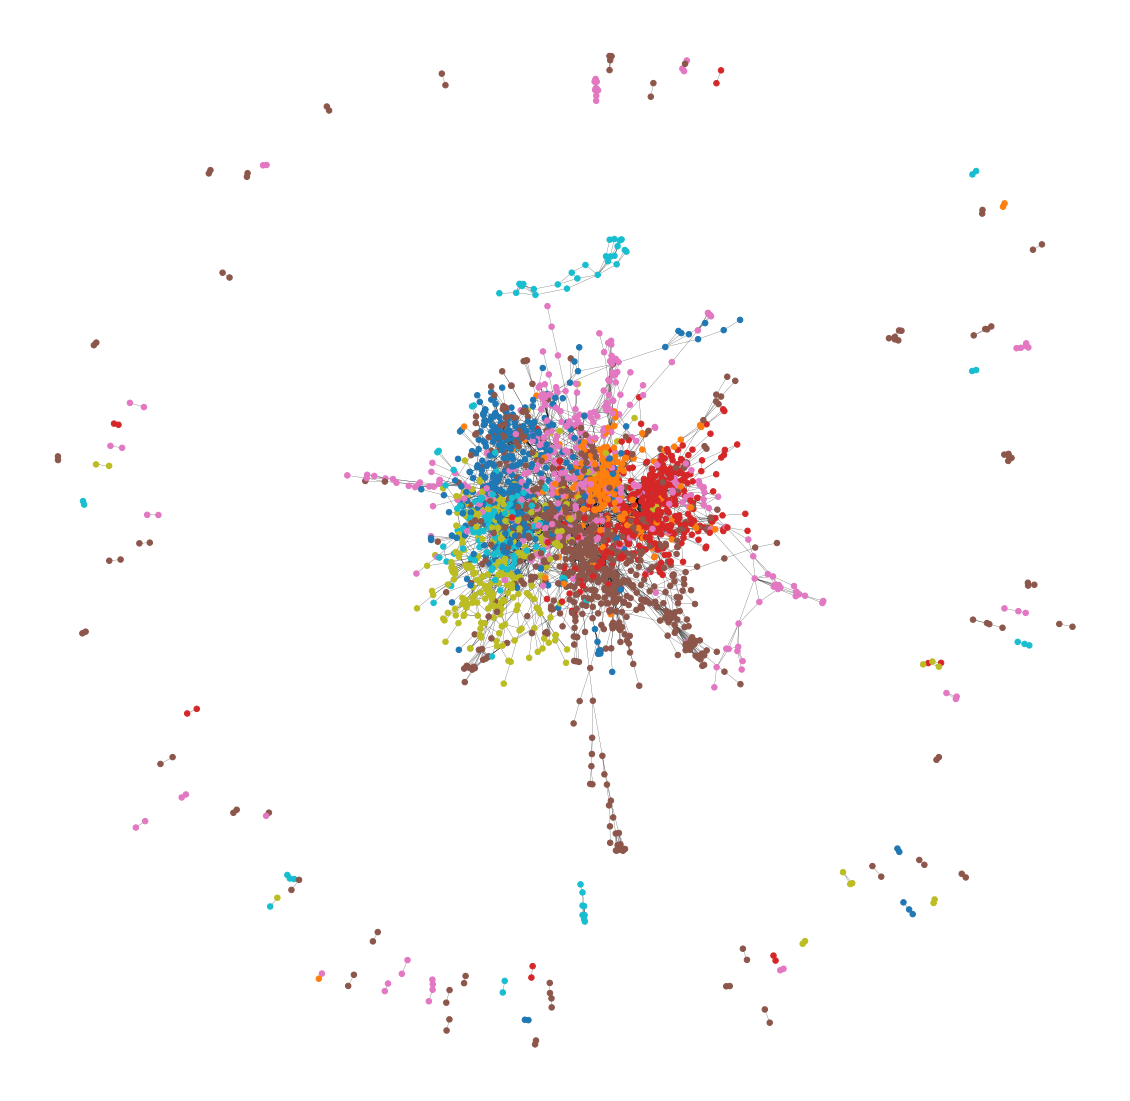

In [14]:
plot_dataset(dataset)

## Network

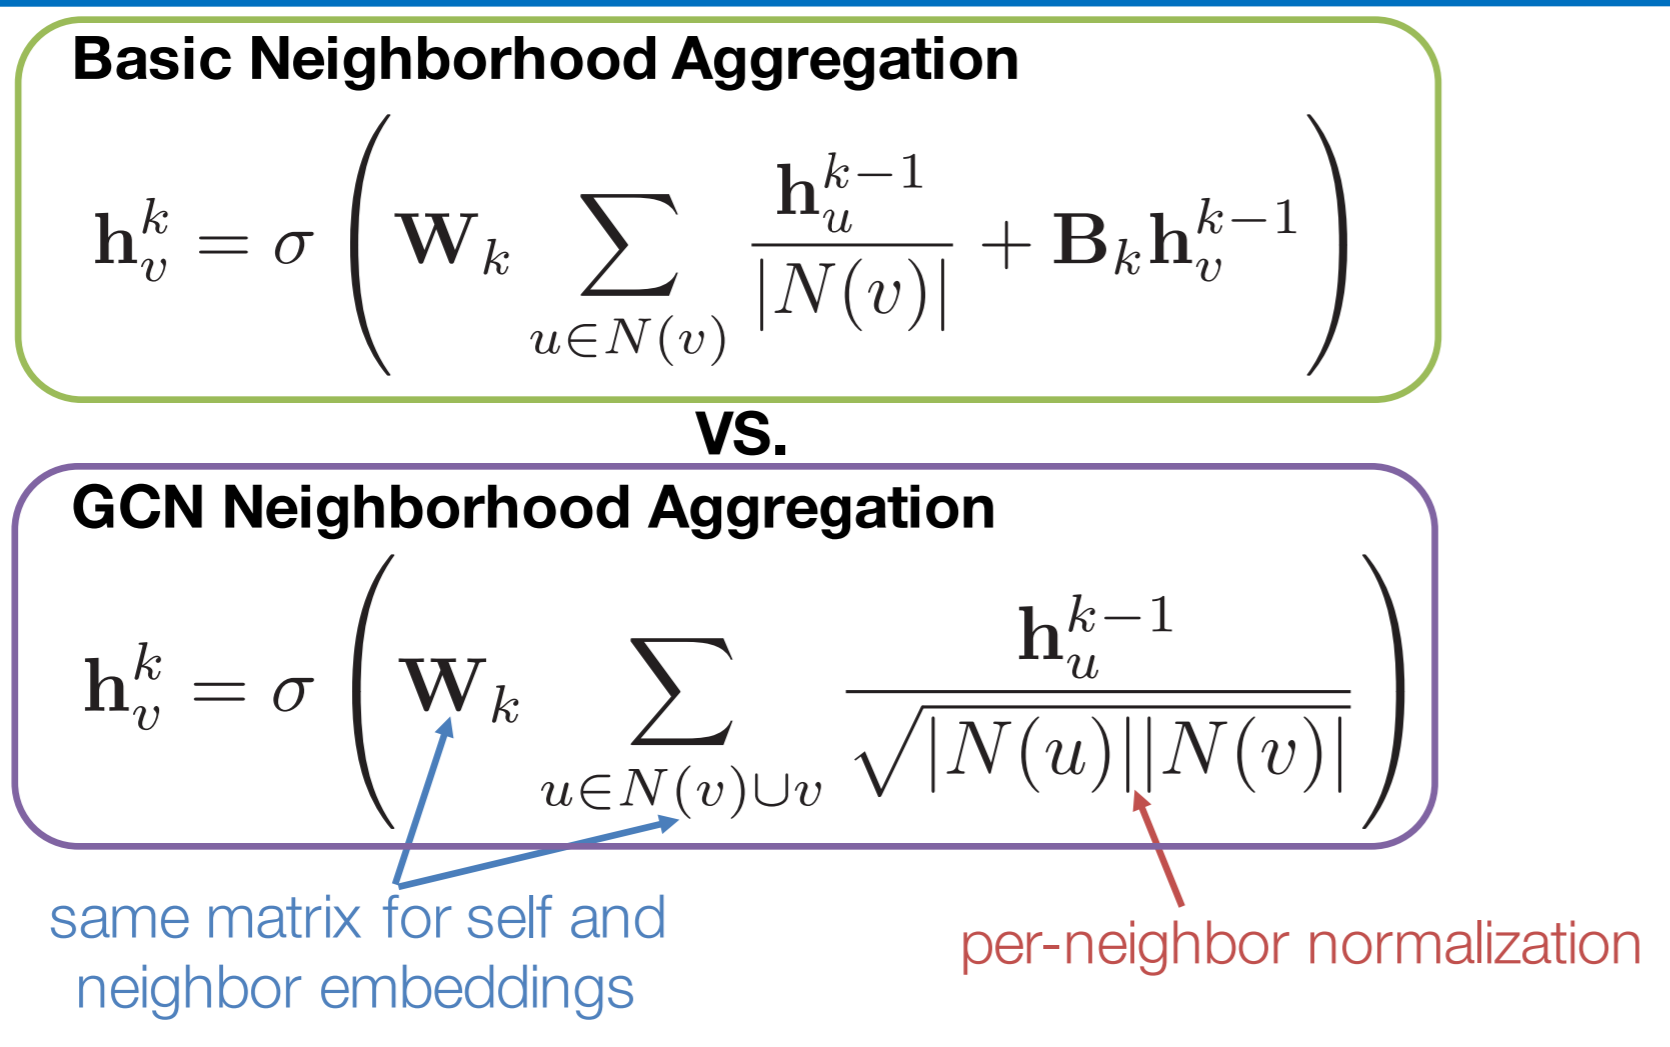

In [19]:
from IPython.display import Image
Image(filename='gcn.png',width=450, height=300)

In [8]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation
        self.w = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        x = self.w(x)
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
                              norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

In [9]:
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

## Training & Testing

In [7]:
def test(data, train=True):
    model.eval()
    correct = 0
    pred = model(data).max(dim=1)[1]
    if train:
        correct += pred[data.train_mask].eq(data.y[data.train_mask]).sum().item()
        return correct / (len(data.y[data.train_mask]))
    else:
        correct += pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
        return correct / (len(data.y[data.test_mask]))

In [6]:
def train(data, plot=False):
    train_accuracies, test_accuracies = list(), list()
    for epoch in range(100):
            model.train()
            optimizer.zero_grad()
            out = model(data)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            train_acc = test(data)
            test_acc = test(data, train=False)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f}'.
                  format(epoch, loss, train_acc, test_acc))

    if plot:
        plt.plot(train_accuracies, label="Train accuracy")
        plt.plot(test_accuracies, label="Validation accuracy")
        plt.xlabel("# Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='upper right')
        plt.show()

Epoch: 000, Loss: 1.95128, Train Acc: 0.24286, Test Acc: 0.14400
Epoch: 001, Loss: 1.89743, Train Acc: 0.36429, Test Acc: 0.19100
Epoch: 002, Loss: 1.81846, Train Acc: 0.50714, Test Acc: 0.25800
Epoch: 003, Loss: 1.74564, Train Acc: 0.62857, Test Acc: 0.31500
Epoch: 004, Loss: 1.65635, Train Acc: 0.72857, Test Acc: 0.43400
Epoch: 005, Loss: 1.57948, Train Acc: 0.82143, Test Acc: 0.50100
Epoch: 006, Loss: 1.46883, Train Acc: 0.85000, Test Acc: 0.54700
Epoch: 007, Loss: 1.35835, Train Acc: 0.87857, Test Acc: 0.58200
Epoch: 008, Loss: 1.25152, Train Acc: 0.90000, Test Acc: 0.63200
Epoch: 009, Loss: 1.14638, Train Acc: 0.90714, Test Acc: 0.66800
Epoch: 010, Loss: 1.06601, Train Acc: 0.93571, Test Acc: 0.68900
Epoch: 011, Loss: 0.98642, Train Acc: 0.95714, Test Acc: 0.70500
Epoch: 012, Loss: 0.89851, Train Acc: 0.97143, Test Acc: 0.72100
Epoch: 013, Loss: 0.82095, Train Acc: 0.97143, Test Acc: 0.73400
Epoch: 014, Loss: 0.71113, Train Acc: 0.98571, Test Acc: 0.74800
Epoch: 015, Loss: 0.65461

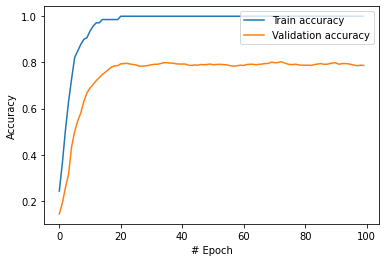

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
train(data, plot=True)

# Acknowledgements & Useful Links

- [Program a simple Graph Net in PyTorch](https://towardsdatascience.com/program-a-simple-graph-net-in-pytorch-e00b500a642d)
- [Hands-on Graph Neural Networks with PyTorch & PyTorch Geometric](https://medium.com/@huangkh19951228/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8)
- [Pytorch Geometric Documentation](https://pytorch-geometric.readthedocs.io/)
- [NetworkX Documentation](https://networkx.org/) 
- [Stanford Representation Learning for Networks](http://snap.stanford.edu/proj/embeddings-www/files/nrltutorial-part2-gnns.pdf)
